In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import time
import os
import numpy as np
import matplotlib.pyplot as plt

In [28]:
print(tf.__version__)

2.0.0


In [29]:
SEED = 2019
tf.random.set_seed(SEED)

In [30]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
PATH = "/kaggle/input/ann-and-dl-image-segmentation/Segmentation_Dataset"
epochs = 5
batch_size = 8

In [58]:
apply_data_augmentation = False

# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    train_img_data_gen = ImageDataGenerator(rotation_range=10,
                                        horizontal_flip=True,
                                        vertical_flip=False,  
                                        fill_mode='nearest',                           
                                        rescale=1./255,
                                        validation_split=0.2)
    train_mask_data_gen = ImageDataGenerator(rotation_range=10,
                                        horizontal_flip=True,
                                        vertical_flip=False,  
                                        fill_mode='nearest',                           
                                        rescale=1./255,
                                        validation_split=0.2) 
else:
    train_img_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    train_mask_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [59]:
dataset_dir = os.path.join(PATH, 'training')

train_img_gen = train_img_data_gen.flow_from_directory(os.path.join(dataset_dir, 'images'),
                                               batch_size=batch_size,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode=None,
                                               shuffle=True,
                                               subset='training',
                                               interpolation='bilinear',
                                               seed=SEED)

train_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(dataset_dir, 'masks'),
                                               batch_size=batch_size,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode=None,
                                               shuffle=True,
                                               subset='training',
                                               interpolation='bilinear',
                                               color_mode='grayscale',
                                               seed=SEED)

train_gen = zip(train_img_gen, train_mask_gen)

# Validation
valid_img_gen = train_img_data_gen.flow_from_directory(os.path.join(dataset_dir, 'images'),
                                               batch_size=batch_size, 
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode=None,
                                               shuffle=False,
                                               subset='validation',
                                               interpolation='bilinear',
                                               seed=SEED)

valid_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(dataset_dir, 'masks'),
                                               batch_size=batch_size, 
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode=None,
                                               shuffle=False,
                                               subset='validation',
                                               interpolation='bilinear',
                                               color_mode='grayscale',
                                               seed=SEED)

valid_gen = zip(valid_img_gen, valid_mask_gen)

Found 6118 images belonging to 1 classes.
Found 6118 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.


In [60]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 4, figsize=(15, 15))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

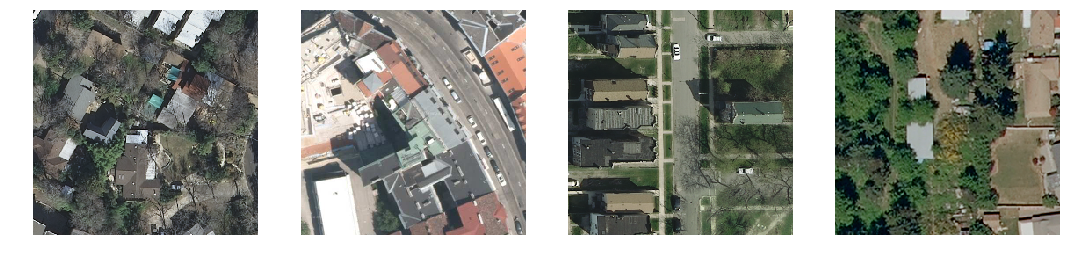

In [61]:
sample_training_images, _ = next(train_gen)
plotImages(sample_training_images[:4])

In [62]:
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, IMG_HEIGHT, IMG_WIDTH, 3], [None, IMG_HEIGHT, IMG_WIDTH, 1]))

'''When using data augmentation on masks it's a good idea to cast mask tensor to tf.int32. 
When applying geometric transformations, like rotation or zoom, the output is interpolated so you will end up with values in [0, 1] 
which are no longer binary. Casting to integer will allow to obtain again binary masks.'''

def prepare_target(x_, y_):
    y_ = tf.cast(y_, tf.int32)
    return x_, y_

train_dataset = train_dataset.map(prepare_target)
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, IMG_HEIGHT, IMG_WIDTH, 3], [None, IMG_HEIGHT, IMG_WIDTH, 1]))

valid_dataset = valid_dataset.map(prepare_target)
valid_dataset = valid_dataset.repeat()

InvalidArgumentError: ValueError: `generator` yielded an element of shape (8, 256, 256, 3) where an element of shape (None, 256, 256, 1) was expected.
Traceback (most recent call last):

  File "/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/ops/script_ops.py", line 221, in __call__
    ret = func(*args)

  File "/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 621, in generator_py_func
    "of shape %s was expected." % (ret_array.shape, expected_shape))

ValueError: `generator` yielded an element of shape (8, 256, 256, 3) where an element of shape (None, 256, 256, 1) was expected.


	 [[{{node PyFunc}}]] [Op:IteratorGetNextSync]

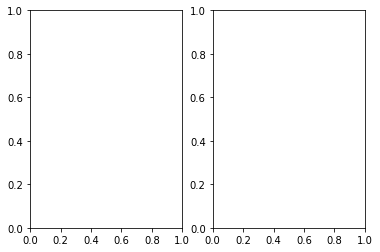

In [63]:
fig, ax = plt.subplots(1, 2)
fig.show()

colors_dict = {}
colors_dict[0] = [0, 0, 0] # Background
colors_dict[1] = [255, 255, 255] # Buildings

iterator = iter(train_dataset)

for _ in range(1):
    augmented_img, target = next(iterator)
    augmented_img = augmented_img[0]
    augmented_img = augmented_img * 255
    
    target = np.array(target[0, ..., 0])
            
    target_img = np.zeros([target.shape[0], target.shape[1], 3])
    
    target_img[np.where(target == 0)] = colors_dict[0]
    target_img[np.where(target == 1)] = colors_dict[1]
    
    ax[0].imshow(np.uint8(augmented_img))
    ax[1].imshow(np.uint8(target_img))

# Model

In [47]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [48]:
def UNet():
    f = [8, 16, 32, 64, 64]
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #256 -> 128
    c2, p2 = down_block(p1, f[1]) #128 -> 64
    c3, p3 = down_block(p2, f[2]) #64 -> 32
    c4, p4 = down_block(p3, f[3]) #32-> 16
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #16 -> 32
    u2 = up_block(u1, c3, f[2]) #32 -> 64
    u3 = up_block(u2, c2, f[1]) #64 -> 128
    u4 = up_block(u3, c1, f[0]) #128 -> 256
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

In [49]:
def IoU(y_true, y_pred):
    # from probability to predicted class {0, 1}
    y_pred = tf.cast(y_pred > 0.5, tf.float32) # when using sigmoid. Use argmax for softmax
    # A and B
    intersection = tf.reduce_sum(y_true * y_pred)
    # A or B
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    # IoU
    return intersection / union

In [50]:
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

In [51]:
model = UNet()
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[IoU])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 8)  224         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 8)  584         conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 128, 128, 8)  0           conv2d_39[0][0]                  
____________________________________________________________________________________________

# Training

In [52]:
from datetime import datetime

callbacks = []

# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callback = tf.keras.callback.EarlyStopping(monitor='val_loss', patience=6)
    callbacks.append(es_callback)

In [53]:
model.fit(x=train_dataset,
          epochs=10,
          steps_per_epoch=len(train_img_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_img_gen), 
          callbacks=callbacks)

model.save_weights("UNet_" + str(datetime.now().strftime('%b%d_%H-%M')) + ".h5")

Train for 765 steps, validate for 192 steps
Epoch 1/10
  1/765 [..............................] - ETA: 2:30

ValueError: logits and labels must have the same shape ((None, 256, 256, 1) vs (None, 256, 256, 3))

In [ ]:
from ipywidgets import FileUpload
upload = FileUpload()
upload

In [ ]:
for i, meta in enumerate(upload.metadata): 
    print(meta['name']) 
    with open(meta['name'], "w+b") as file_writer: 
        file_writer.write(upload.data[i])

In [26]:
#model.load_weights

image_filenames = next(os.walk('/kaggle/input/ann-and-dl-image-segmentation/Segmentation_Dataset/test/images/img'))[2]

results = {}
for image_name in image_filenames[:1]:

    img = image.load_img(os.path.join('/kaggle/input/ann-and-dl-image-segmentation/Segmentation_Dataset/test/images/img', image_name), target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor /= 255. 
        
    results[image_name[:-4]] = model.predict(img_tensor)
    print(results[image_name[:-4]])
    results[image_name[:-4]] = tf.cast(results[image_name[:-4]] > 0.5, tf.float32)

[[[[0.41304544]
   [0.41304544]
   [0.41304544]
   ...
   [0.41304544]
   [0.41304544]
   [0.41304544]]

  [[0.41304544]
   [0.41304544]
   [0.41304544]
   ...
   [0.41304544]
   [0.41304544]
   [0.41304544]]

  [[0.41304544]
   [0.41304544]
   [0.41304544]
   ...
   [0.41304544]
   [0.41304544]
   [0.41304544]]

  ...

  [[0.41304544]
   [0.41304544]
   [0.41304544]
   ...
   [0.41304544]
   [0.41304544]
   [0.41304544]]

  [[0.41304544]
   [0.41304544]
   [0.41304544]
   ...
   [0.41304544]
   [0.41304544]
   [0.41304544]]

  [[0.41304544]
   [0.41304544]
   [0.41304544]
   ...
   [0.41304544]
   [0.41304544]
   [0.41304544]]]]


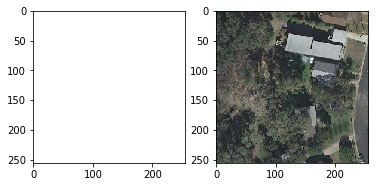

In [24]:
results['492'] =  tf.cast(results['492'], tf.float32)
    
result = np.array(results['492'][0, ..., 0])

result_img = np.zeros([result.shape[0], result.shape[1], 3])

result_img[np.where(result == 0)] = [0, 0, 0]
result_img[np.where(result == 1)] = [255, 255, 255]

fig, ax = plt.subplots(1, 2)
fig.show()

ax[0].imshow(np.uint8(result_img))
ax[1].imshow(np.uint8(img_tensor[0] * 255))

In [ ]:
def rle_encode(img):
    # Flatten column-wise
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

#for img_name in results[:1]:
#    print(rle_encode(np.array(results[img_name])))

In [ ]:
def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(csv_fname, 'w') as f:

        f.write('ImageId,EncodedPixels,Width,Height\n')

        for key, value in results.items():
            f.write(key + ',' + str(rle_encode(np.array(value))) + ',' + '256' + ',' + '256' + '\n')

In [ ]:
create_csv(results)